In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

In [2]:
import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

## Set up and run the microlensing metric. ## 

The microlensing metric is similar to the KNe metric, in that it requires a microlensing-specific slicer (a UserPoints slicer combined with information about the microlensing events and lightcurves) together with the microlensing detection metric. 

The population distribution for the microlensing metric is currently a simple N^2 distribution of events (N being the stellar density at that point in the sky). Events occur with a variety of crossing times, and evaluation of the detection likelilhood in the metric is split up between different intervals; in general longer crossing times are easier to detect and can overwhelm the detection sensitivity to shorter timescale events.

In [3]:
baseline_file = get_baseline()
opsim = os.path.basename(baseline_file).replace('.db','')
opsdb = maf.db.OpsimDatabase(baseline_file)
print(f'running on {opsim}')

running on baseline_nexp2_v1.7_10yrs


In [4]:
metric = maf.MicrolensingMetric()
summaryMetrics = maf.batches.lightcurveSummary()

In [5]:

n_events = 10000
bundles = {}
# Let's evaluate a variety of crossing times
crossing_times = [[1, 5,], [5, 10], [10, 20], [20, 30], [30, 60], [60, 90], [100, 200], [200, 500], [500, 1000]]
for crossing in crossing_times:
    key = f'{crossing[0]} to {crossing[1]}'
    slicer = maf.generateMicrolensingSlicer(min_crossing_time=crossing[0], max_crossing_time=crossing[1], 
                                            n_events=n_events)
    bundles[key] = maf.MetricBundle(metric, slicer, None, runName=opsim, 
                                            summaryMetrics=summaryMetrics, 
                                            metadata=f'crossing {crossing[0]} to {crossing[1]} days')

In [6]:
print(bundles.keys())

dict_keys(['1 to 5', '5 to 10', '10 to 20', '20 to 30', '30 to 60', '60 to 90', '100 to 200', '200 to 500', '500 to 1000'])


In [7]:
outDir = 'test_microlensing'
g = maf.MetricBundleGroup(bundles, opsdb, outDir)

In [8]:
g.runAll()

Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fiveSigmaDepth', 'rotSkyPos', 'filter', 'fieldDec', 'night', 'fieldRA'].
Found 2045493 visits
Running:  ['1 to 5']
Completed metric generation.
Running:  ['5 to 10']
Completed metric generation.
Running:  ['10 to 20']
Completed metric generation.
Running:  ['20 to 30']
Completed metric generation.
Running:  ['30 to 60']
Completed metric generation.
Running:  ['60 to 90']
Completed metric generation.
Running:  ['100 to 200']
Completed metric generation.
Running:  ['200 to 500']
Completed metric generation.
Running:  ['500 to 1000']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [9]:
bundles.keys()

dict_keys(['1 to 5', '5 to 10', '10 to 20', '20 to 30', '30 to 60', '60 to 90', '100 to 200', '200 to 500', '500 to 1000'])

In [10]:
d = pd.DataFrame([bundles[k].summaryValues for k in bundles.keys()], index=list(bundles.keys()))
d

Total detected  Total lightcurves in footprint  \
1 to 5               1117.0                            9992   
5 to 10              1822.0                            9992   
10 to 20             2547.0                            9992   
20 to 30             3357.0                            9992   
30 to 60             5042.0                            9992   
60 to 90             7388.0                            9992   
100 to 200           9667.0                            9992   
200 to 500           9714.0                            9992   
500 to 1000          9459.0                            9992   

             Total lightcurves on sky  Fraction detected in footprint (mean)  \
1 to 5                          10000                               0.111789   
5 to 10                         10000                               0.182346   
10 to 20                        10000                               0.254904   
20 to 30                        10000                               0.335969   
30 to 60                        10000                               0.504604   
60 to 90                        10000                               0.739392   
100 to 200                      10000                               0.967474   
200 to 500                      10000                               0.972178   
500 to 1000                     10000                               0.946657   

             Fraction detected of total (mean)  
1 to 5                                  0.1117  
5 to 10                                 0.1822  
10 to 20                                0.2547  
20 to 30                                0.3357  
30 to 60                                0.5042  
60 to 90                                0.7388  
100 to 200                              0.9667  
200 to 500                              0.9714  
500 to 1000                             0.9459

[0.1117, 0.1822, 0.2547, 0.3357, 0.5042, 0.7388, 0.9667, 0.9714, 0.9459] [   1.     125.875  250.75   375.625  500.5    625.375  750.25   875.125
 1000.   ]


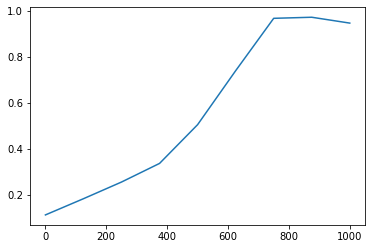

In [56]:
eficiencia = []
for j in range(9):
    eficiencia.append(d.iat[j,0]/d.iat[0,2])

te = np.linspace(1,1000,9)
plt.plot(te, eficiencia)
print(eficiencia,te)

## Look at the metric outputs. ##

The microlensing metric can output two different kinds of results; if 'detect' is True (the default), then it outputs 0-1 depending on whether an event was detected or not.

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


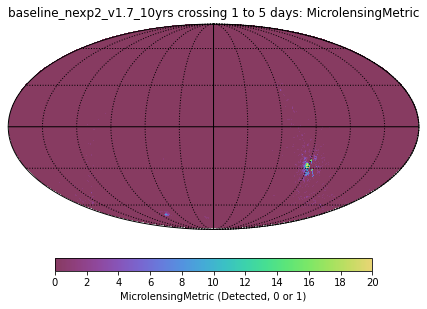

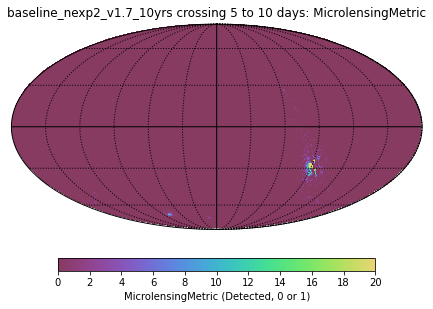

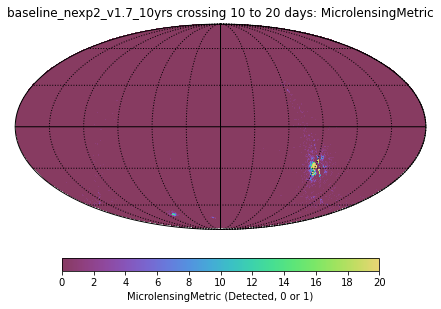

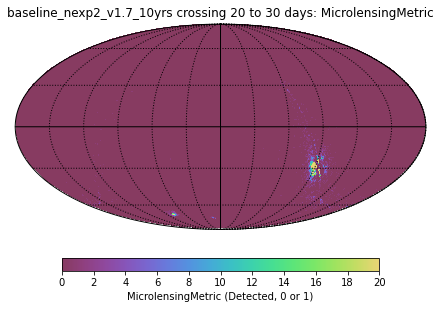

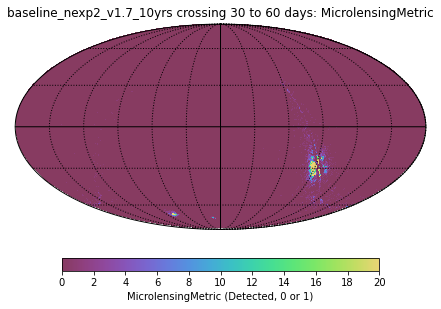

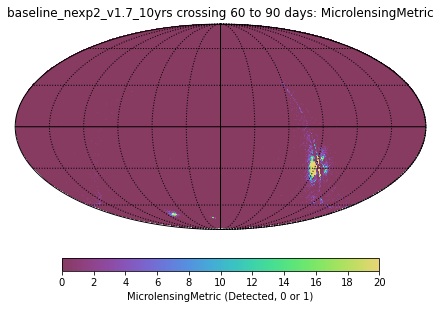

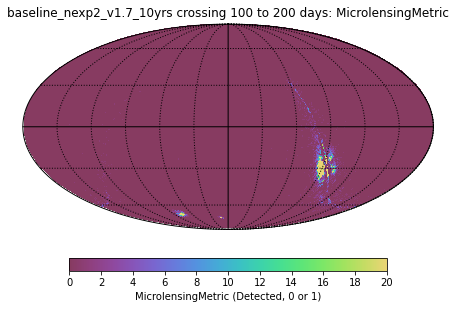

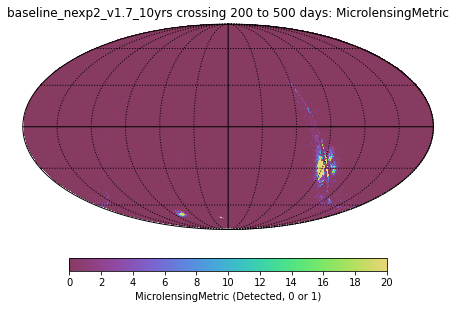

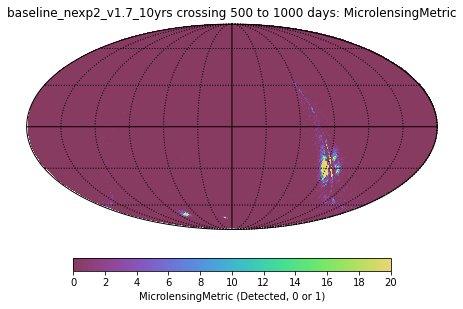

In [11]:
# If you don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0, 'colorMax': 20}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bundles:
    ph.setMetricBundles([bundles[k]])
    ph.plot(plotFunc=plotFunc, plotDicts=plotDict)

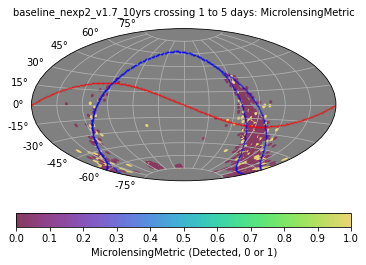

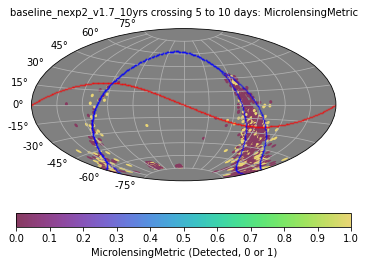

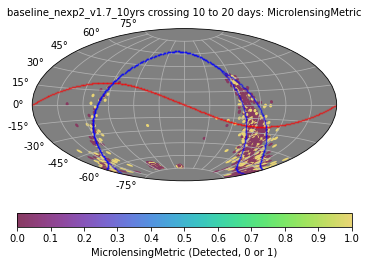

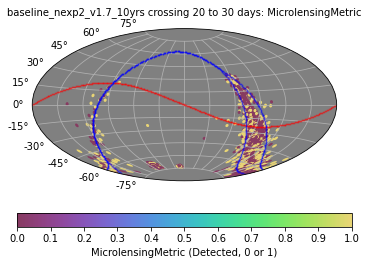

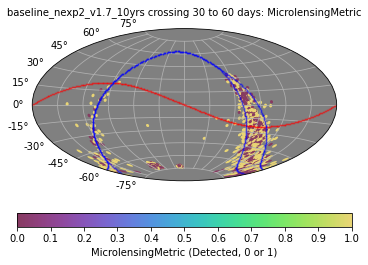

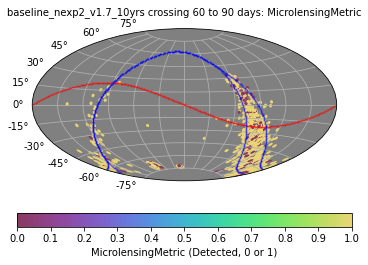

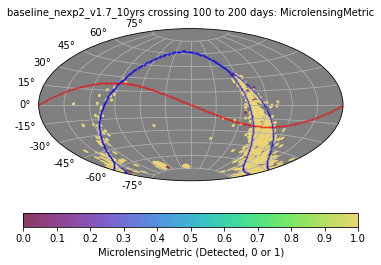

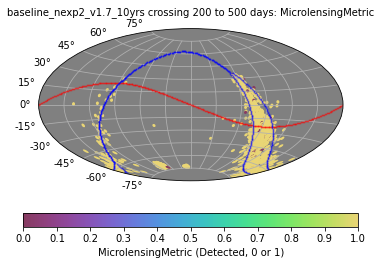

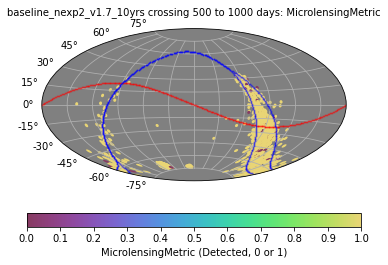

In [57]:
# If you do want to show each individual point - this is slower but shows each individual event
plotFunc = maf.plots.BaseSkyMap()

ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bundles:
    ph.setMetricBundles([bundles[k]])
    ph.plot(plotFunc=plotFunc)

In [67]:
# d = pd.DataFrame([bundles[k].summaryValues for k in bundles.keys()], index=list(bundles.keys()))
# d

In [66]:
# plt.plot(d['Total detected'])
# plt.xticks(rotation=90)
# plt.title(f'Total detected / {n_events} as function of crossing time')

In [65]:
# d['Total detected'].iat[1]
# plt.plot(d['Total detected'])